In [1]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

spark = SparkSession.builder.appName("EnergySourceClassification").getOrCreate()

dataset_path = (r"C:\Users\sanja\Desktop\Big Data\World Energy Consumption.csv")

data = spark.read.csv(dataset_path, header=True, inferSchema=True)

data.select('renewables_share_energy').summary().show()

+-------+-----------------------+
|summary|renewables_share_energy|
+-------+-----------------------+
|  count|                   4284|
|   mean|      9.769008636788044|
| stddev|     13.166013905306468|
|    min|                    0.0|
|    25%|                  1.003|
|    50%|                  5.051|
|    75%|                 13.183|
|    max|                 82.835|
+-------+-----------------------+



In [2]:
threshold_renewable = 9.7

data = data.withColumn("label", (data["renewables_share_energy"] > threshold_renewable).cast("double"))

In [3]:

feature_columns = ["coal_share_energy", "gas_share_energy", "oil_share_energy", "renewables_share_energy"]

assembler = VectorAssembler(inputCols=feature_columns, outputCol="features", handleInvalid = "skip")
data = assembler.transform(data)

In [4]:
train_data, test_data = data.randomSplit([0.7, 0.3], seed=123)

# Logistic Regression
lr = LogisticRegression(labelCol="label", featuresCol="features", maxIter=100, regParam=0.01)
model = lr.fit(train_data)

In [5]:
# Make predictions on the test data
predictions = model.transform(test_data)

In [6]:

# Evaluate the model's performance using a MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"Accuracy: {accuracy}")


Accuracy: 0.9575289575289575


In [7]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import LogisticRegression
from pyspark.mllib.evaluation import MulticlassMetrics

# Precision, Recall, F1-Score
tp = predictions.filter((predictions["label"] == 1) & (predictions["prediction"] == 1)).count()
tn = predictions.filter((predictions["label"] == 0) & (predictions["prediction"] == 0)).count()
fp = predictions.filter((predictions["label"] == 0) & (predictions["prediction"] == 1)).count()
fn = predictions.filter((predictions["label"] == 1) & (predictions["prediction"] == 0)).count()



In [8]:

precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1_score = 2 * (precision * recall) / (precision + recall)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1_score}")


Precision: 0.9969788519637462
Recall: 0.859375
F1-Score: 0.9230769230769231


In [9]:
# Confusion Matrix
metrics = MulticlassMetrics(predictions.select("label", "prediction").rdd)
confusion_matrix = metrics.confusionMatrix()

print("Confusion Matrix:")
print(confusion_matrix)

C:\Users\sanja\anaconda3\envs\spart\lib\site-packages\pyspark\sql\context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Confusion Matrix:
DenseMatrix([[910.,  54.],
             [  1., 330.]])


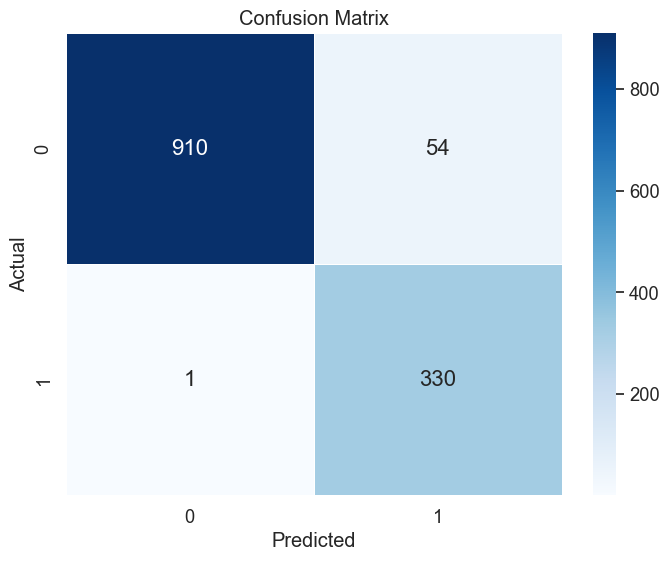

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Getting the confusion matrix from the MulticlassMetrics object
confusion_matrix = metrics.confusionMatrix().toArray()

# heatmap
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(confusion_matrix, annot=True, fmt="g", cmap="Blues", linewidths=.5, annot_kws={"size": 16})
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
spark.stop()